In [1]:
import pystan
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter('ignore')

import pymc3 as pm

In [2]:
""" Preparing the dataset  """

#Loading data
data = pd.read_csv('co2.csv', skiprows=44, names=['date','level'])
data["date"] = pd.to_datetime(data["date"])
#Preprocessing to days in between the measurement dates
data['days between'] = (data['date'] - data['date'][0]).dt.days

time = data['date']
levels = data['level']

In [3]:
data.head()

,date,level,days between
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28


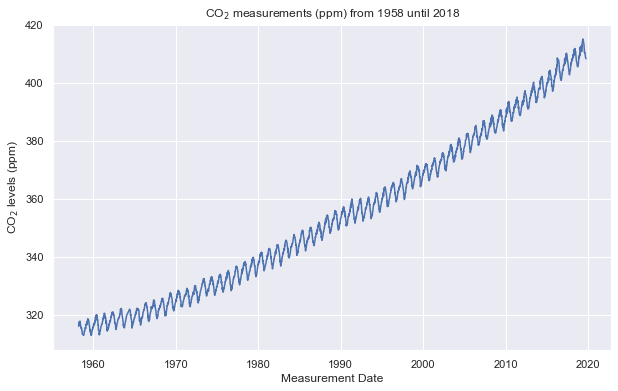

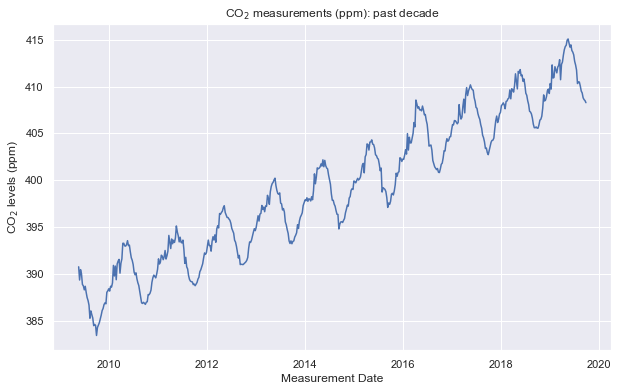

In [4]:
""" Plotting the dataset  """

#Plotting the overall trend of the data
plt.figure(figsize = (10,6))
plt.plot(data['date'],data['level'])
plt.xlabel('Measurement Date')
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.title(r'CO$_2$ measurements (ppm) from 1958 until 2018')
plt.show()

#Zooming into the trend of the past decade
plt.figure(figsize = (10,6))
plt.plot(data['date'][2600:],data['level'][2600:])
plt.xlabel('Measurement Date')
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.title(r'CO$_2$ measurements (ppm): past decade')
plt.show()

In [5]:
""" Data for the Time Trend Models """
# Defining the data for Stan: 
# num - the int number of datapoints;
# levels - measurements column of the data;
# time - days between column of the data.

trend_model_data = {
    'num': len(data),
    'levels': data['level'],
    'time': data['days between']}

In [6]:
""" Linear Time Trend Model 
"""
# Defining the data, parameters, and model block: we need to specify what data to expect, 
# the parameters we are using, and the prior and likelihood. 


linear_stan = """
data {
    int<lower=0> num;  // number of collected data points
    real<lower=0> levels[num];  // data for levels
    real<lower=0> time[num]; // data for days
}

parameters {
    real<lower=0> c_0;  // intercept
    real<lower=0> c_1;  // 1st degree polynomial 
    real<lower=0> sigma; //random noise
}


model {
    // priors 
    c_0 ~ normal(300, 30);
    c_1 ~ normal(0,1);
    sigma ~ normal(0, 8);
    
    // model
    for (i in 1:num) {   
        levels[i] ~ normal(c_0 + c_1*time[i], sigma);
        }    
}

"""

In [7]:
""" Quadratic Time Trend Model 
"""
# Defining the data, parameters, and model block: we need to specify what data to expect, 
# the parameters we are using, and the prior and likelihood. 

quad_stan = """
data {
    int<lower=0> num;  // number of collected data points
    real<lower=0> levels[num];  // data for levels
    real<lower=0> time[num]; // data for days
}

parameters {
    real<lower=0> c_0;  // intercept
    real<lower=0> c_1;  // 1st degree polynomial 
    real<lower=0> c_2;  // 2nd degree polynomial 
    real<lower=0> sigma; //random noise
}


model {
    // priors 
    c_0 ~ normal(300, 30);
    c_1 ~ normal(0,1);
    c_2 ~ normal(0,1);
    sigma ~ normal(0, 8);
    
    // model
    for (i in 1:num) {   
        levels[i] ~ normal(c_0 + c_1*time[i] + c_2*time[i]^2, sigma);
        }    
}

"""

In [8]:
""" Compiling the two Stan models """
linear_model = pystan.StanModel(model_code=linear_stan)
quad_model = pystan.StanModel(model_code=quad_stan)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc07826d6aaa8c6db39ddf06e46626ae NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ef668f9d613a22537e9af9f3f28bf95 NOW.


In [9]:
""" Fitting the models to the data and printing results for our parameters """

#Getting results from the linear model
linear_results = linear_model.sampling(data=trend_model_data)
linear = linear_results.extract()

#Getting results from the quadratic model
quad_results = quad_model.sampling(data=trend_model_data)
quad = quad_results.extract()

print(linear_results)
print(quad_results)

Inference for Stan model: anon_model_bc07826d6aaa8c6db39ddf06e46626ae.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0   306.07  3.4e-3   0.15 305.76 305.97 306.07 306.17 306.36   2106    1.0
c_1   4.3e-3  2.7e-7 1.2e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   1874    1.0
sigma   4.27  1.4e-3   0.05   4.16   4.23   4.27    4.3   4.37   1397    1.0
lp__   -6123    0.03   1.19  -6126  -6124  -6123  -6122  -6122   1298    1.0

Samples were drawn using NUTS at Thu Dec 19 13:24:37 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Inference for Stan model: anon_model_5ef668f9d613a22537e9af9f3f28bf95.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean s

In [10]:
#Visualizing linear model results in a table/dataframe form
linear_summary = pd.DataFrame(pm.summary(linear_results))
linear_summary[['mean', 'sd', 'ess_bulk', 'r_hat']]

,mean,sd,ess_bulk,r_hat
c_0,306.068,0.154,2116.0,1.0
c_1,0.004,0.000,1874.0,1.0
sigma,4.268,0.053,1414.0,1.0


In [11]:
#Visualizing quadratic model results in a table/dataframe form
quad_summary = pd.DataFrame(pm.summary(quad_results))
quad_summary[['mean', 'sd', 'ess_bulk', 'r_hat']]

,mean,sd,ess_bulk,r_hat
c_0,314.572,0.121,1689.0,1.0
c_1,0.002,0.000,1536.0,1.0
c_2,0.000,0.000,1600.0,1.0
sigma,2.250,0.028,1273.0,1.0


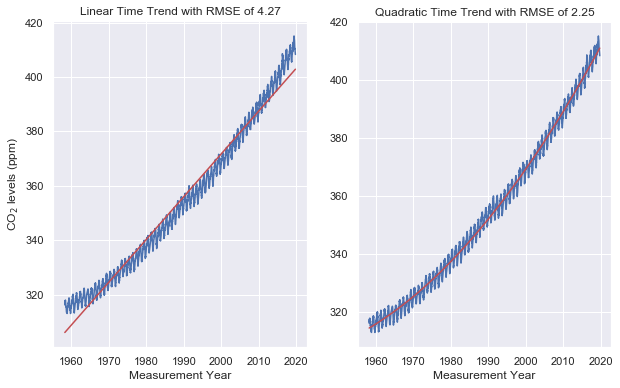

In [12]:
""" Comparing the two time trend models """

#Getting the time values in days in between
t = data['days between'].values

#Getting the generated parameters from the linear model
l_noise = linear['sigma']
l_c_0 = linear['c_0']
l_c_1 = linear['c_1']
l = l_c_0.mean() + l_c_1.mean()*t

#Getting the generated parameters from the quadratic model
q_noise = quad['sigma']
q_c_0 = quad['c_0']
q_c_1 = quad['c_1']
q_c_2 = quad['c_2']
q = q_c_0.mean() + q_c_1.mean()*t + q_c_2.mean()*t**2

#Getting the sample means from the linear model to compute the residuals
lin_model_means = []
for i in range(len(data)):
    lin_model_means.append(l_c_0.mean() + l_c_1.mean()*t[i])

lin_residuals = data['level'] - lin_model_means

#Getting the sample means from the quadratic model to compute the residuals
model_means = []
for i in range(len(data)):
    model_means.append(q_c_0.mean() + q_c_1.mean()*t[i] + q_c_2.mean()*t[i]**2)

residuals = data['level'] - model_means

#Plotting the data vs linear model trend line 
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(data['date'], data['level'].values)
plt.plot(data['date'], l, color='r')
plt.xlabel('Measurement Year')
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.title('Linear Time Trend with RMSE of {}'.format(round(np.sqrt(np.mean(lin_residuals**2)),2)))

#Plotting the data vs quadratic model trend line 
plt.subplot(1, 2, 2)
plt.plot(data['date'], data['level'].values)
plt.plot(data['date'], q, color='r')
plt.xlabel('Measurement Year')
plt.title('Quadratic Time Trend with RMSE of {}'.format(round(np.sqrt(np.mean(residuals**2)),2)))

plt.show()

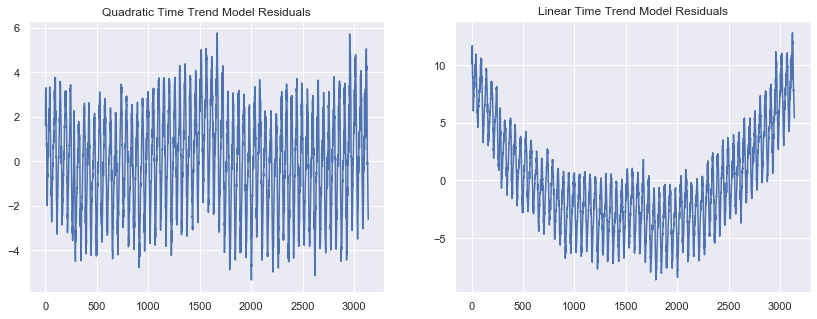

In [13]:
""" Comparing the two time trend models """

#Plotting the residuals for the linear model
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Quadratic Time Trend Model Residuals')

#Plotting the residuals for the quadratic model
plt.subplot(1, 2, 2)
plt.plot(lin_residuals)
plt.title('Linear Time Trend Model Residuals')
plt.show()

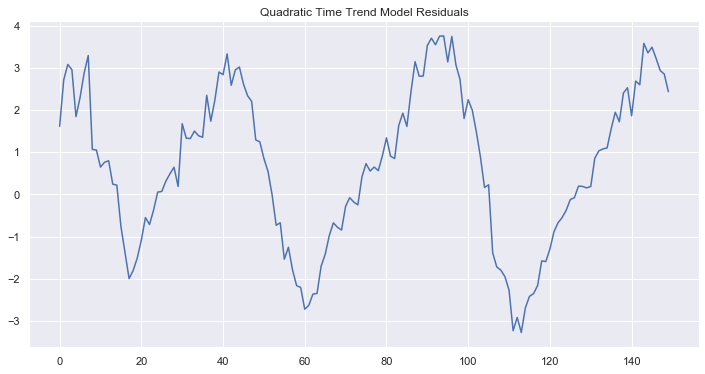

In [14]:
#Zooming in on the residuals from the quadratic model
plt.figure(figsize=(12, 6))
plt.plot(residuals[:150])
plt.title('Quadratic Time Trend Model Residuals')
plt.show()

In [15]:
""" Proposed Quadratic Tilted Sine Model """

# Defining the data for Stan: 
# num - the int number of datapoints;
# levels - measurements column of the data;
# time - days between column of the data.

final_model_data = {
    'num': len(data),
    'levels': data['level'],
    'time': data['days between']}


# Defining the data, parameters, and model block: we need to specify what data to expect, 
# the parameters we are using, and the prior and likelihood. 

final_stan = """
data {
    int<lower=0> num;  // number of collected data points
    real<lower=0> levels[num];  // data for levels         
    real<lower=0> time[num]; // data for days   
}

parameters {
    real<lower=0> c_0;  // intercept
    real<lower=0> c_1;  // 1st degree polynomial 
    real<lower=0> c_2;  // 2nd degree polynomial 
    real<lower=0> sigma; //random noise
    
    real<lower=0> amplitude; 
    real<lower=0,upper=pi()> phi; // phi
}


model {
    // priors 
    c_0 ~ normal(300, 30);
    c_1 ~ normal(0,10);
    c_2 ~ normal(0,10);
    sigma ~ normal(0, 8);
    
    amplitude ~ normal(0,1);
    phi ~ cauchy(0, 10);
       
    
    // model
        for (i in 1:num) {   
            levels[i] ~ normal(c_0 + c_1*time[i] + c_2*time[i]^2 +     
            amplitude/phi*atan((phi*sin((2*pi()*time[i])/365.25)+phi)/
                        (1-phi*cos((2*pi()*time[i])/365.25)+phi)), sigma);
    }
}
"""

#Compiling the model
final_stan_model = pystan.StanModel(model_code=final_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_321fb5ae27a98c091797a739d2afe5a9 NOW.


In [16]:
""" Fitting the model to the data and printing results for our parameters """

parameters = ['c_0','c_1','c_2','amplitude','phi','sigma']

final_results = final_stan_model.sampling(data=final_model_data)
print(final_results.stansummary(pars=parameters))

Inference for Stan model: anon_model_321fb5ae27a98c091797a739d2afe5a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0       312.39  2.1e-3    0.1 312.19 312.32 312.39 312.45 312.59   2278    1.0
c_1       2.1e-3  4.4e-7 1.9e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1785    1.0
c_2       9.7e-8 1.9e-118.0e-10 9.5e-8 9.6e-8 9.7e-8 9.8e-8 9.8e-8   1800    1.0
amplitude   9.47    0.01   0.48   8.52   9.15   9.47    9.8  10.39   1613    1.0
phi         2.76  4.2e-3   0.16   2.43   2.65   2.76   2.88   3.07   1528    1.0
sigma       1.62  4.5e-4   0.02   1.58   1.61   1.62   1.64   1.67   2211    1.0

Samples were drawn using NUTS at Thu Dec 19 13:29:59 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [17]:
#Getting the generated samples for the parameters
final_samples = final_results.extract()

In [18]:
#Visualizing the summary in a table/dataframe format
final_summary = pd.DataFrame(pm.summary(final_results))
final_summary[['mean', 'sd', 'ess_bulk', 'r_hat']]

,mean,sd,ess_bulk,r_hat
c_0,312.386,0.101,2288.0,1.0
c_1,0.002,0.000,1789.0,1.0
c_2,0.000,0.000,1802.0,1.0
sigma,1.623,0.021,2250.0,1.0
amplitude,9.467,0.478,1610.0,1.0
phi,2.760,0.164,1500.0,1.0


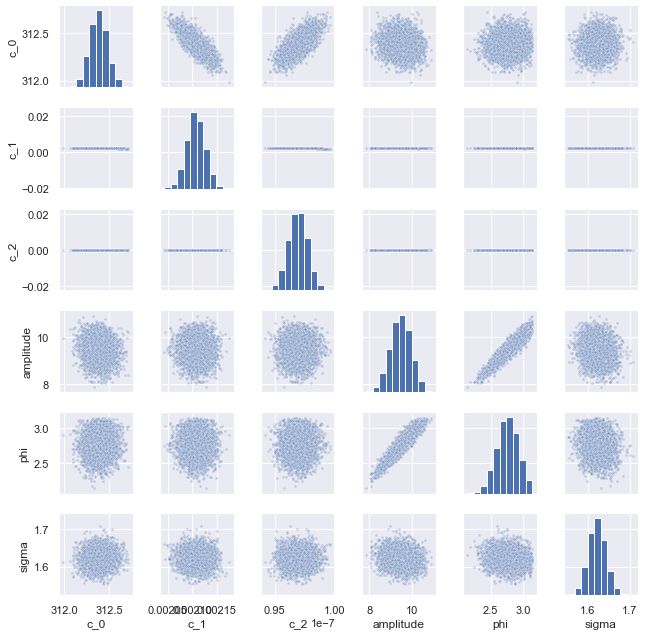

In [19]:
""" Model Performance and Assessment: Pairplots """

#Getting the pairplots
df = pd.DataFrame(data=np.transpose([final_samples[p] for p in parameters]), columns=parameters)
sns.pairplot(df, size=1.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

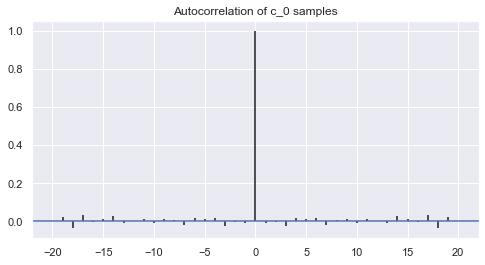

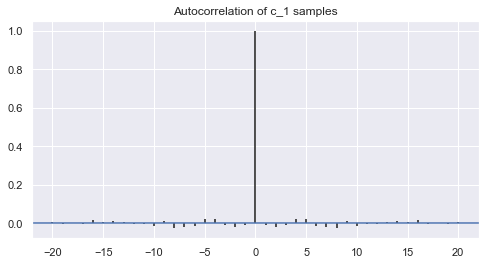

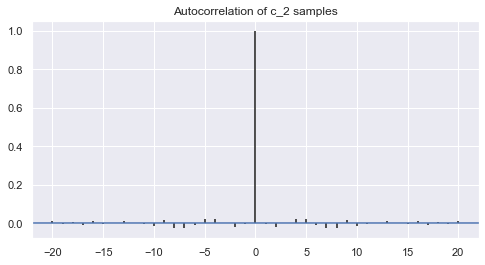

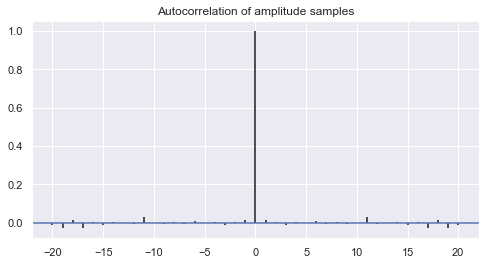

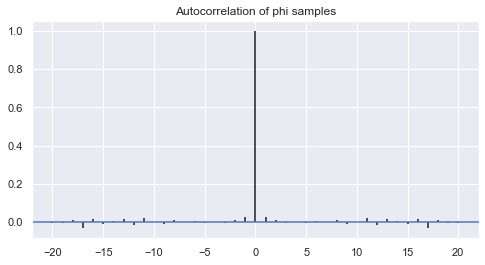

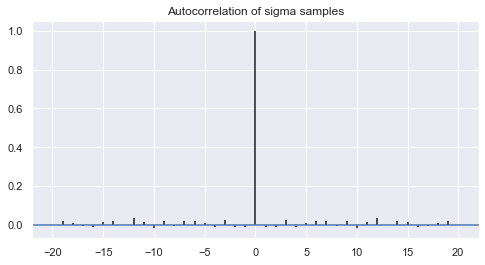

In [20]:
""" Model Performance and Assessment: Autocorrelation """

#Getting the autocorrelation plots
from scipy import signal 
def plot_acf(x): 
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    
    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))
    
for p in parameters:
    plt.figure(figsize=(8,4)) 
    plot_acf(final_samples[p]) 
    plt.title(f'Autocorrelation of {p} samples')
plt.show()

In [22]:
""" Model Performance and Assessment: Posterior Predictive Checks """

#Getting the generated samples
c0_samples = final_samples['c_0']
c1_samples = final_samples['c_1'] 
c2_samples = final_samples['c_2'] 
amp_samples = final_samples['amplitude'] 
phi_samples = final_samples['phi'] 
sigma_samples = final_samples['sigma'] 



#Generating replicated data (the for loop)
time_days = np.array(data['days between'])

#Using the range based on the number of samples used in Stan
model_reps = np.zeros((4000,len(time_days))) 

from numpy import arctan, sin, pi, cos
for s in range(4000):
    model_reps[s,:] = stats.norm.rvs(c0_samples[s] + c1_samples[s]*time_days +
    c2_samples[s]*(time_days)**2 + amp_samples[s]/phi_samples[s]*arctan((phi_samples[s]*sin((2*pi*time_days)/365.25)+
    phi_samples[s])/(1-phi_samples[s]*cos((2*pi*time_days)/365.25)+phi_samples[s])), sigma_samples[s])  

In [23]:
#Getting the RMSE error for the proposed model
print(round(np.mean([np.mean(np.sqrt((data['level'] - model_reps[i,:])**2)) for i in range(len(model_reps))]),2))

1.84


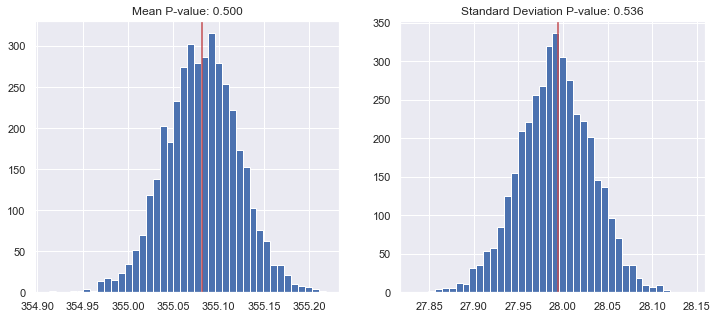

In [43]:
#Plotting the test statistic and corresponding p-value
reps_mean = np.mean(model_reps, axis=1)
actual_mean = np.mean(data['level'].values)

reps_std = np.std(model_reps, axis=1)
actual_std = np.std(data['level'].values)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.hist(reps_mean, bins=40)
plt.axvline(actual_mean, color='r')
plt.title('Mean P-value: {:.3f}'.format(np.mean(reps_mean<actual_mean)))

plt.subplot(1, 2, 2)
plt.hist(reps_std, bins=40)
plt.axvline(actual_std, color='r')
plt.title('Standard Deviation P-value: {:.3f}'.format(np.mean(reps_std<actual_std)))
plt.show()

In [25]:
""" Model Performance and Assessment: Predictions into the Future """

#Predicting 40 years into the future
days_diff = np.array(data['days between'])
num_future = int(days_diff[-1] + 365.25*40)
future_days = np.array(range(days_diff[-1], num_future, 7))

#Sampling from the model for our predictions
def the_model(stat, time, val):  
    return np.array(stats.norm.rvs(stat(c0_samples,val) + stat(c1_samples,val)*time + 
                   stat(c2_samples,val)*(time)**2 + 
                stat(amp_samples,val)*1/stat(phi_samples,val)*arctan((stat(phi_samples,val)*sin((2*pi*time)/365.25)+
                stat(phi_samples,val))*1/(1-stat(phi_samples,val)*cos((2*pi*time)/365.25)+stat(phi_samples,val))), 
                                                                        stat(sigma_samples,val)))

#Getting the predicted quantities 
model_pred_mean = the_model(np.mean, future_days, 0)
model_pred_int_lower = the_model(np.percentile, future_days, 2.5)
model_pred_int_upper = the_model(np.percentile, future_days, 97.5)

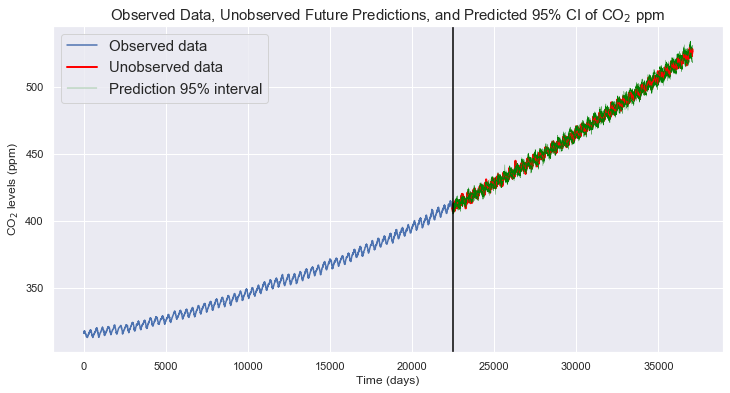

In [26]:
""" Model Performance and Assessment: Visualizing the Predictions """

#Plotting the overall predicted trend
plt.figure(figsize = (12, 6))
plt.plot(np.array(data['days between']),data['level'],label='Observed data')
plt.plot(future_days,model_pred_mean,color='red',label='Unobserved data',linewidth=2)
plt.plot(future_days,model_pred_int_lower,'green', linewidth=0.3,label='Prediction 95% interval')
plt.plot(future_days,model_pred_int_upper,'green',linewidth=0.3)
plt.axvline(future_days[0], color='black')
plt.xlabel('Time (days)')
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.legend(prop={'size': 15})
plt.title(r'Observed Data, Unobserved Future Predictions, and Predicted 95% CI of CO$_2$ ppm',fontsize=15)
plt.show()

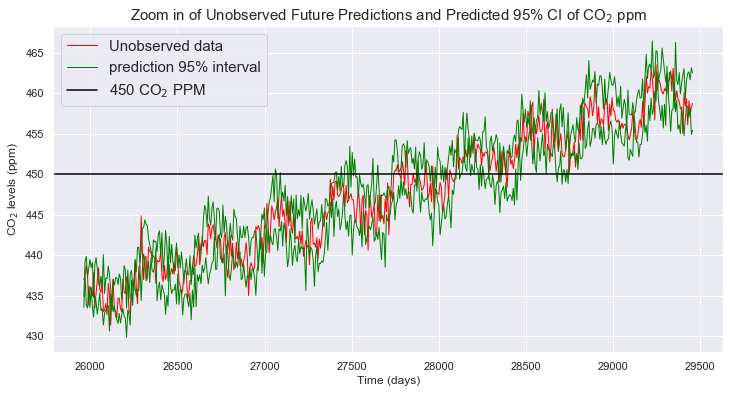

In [27]:
#Zooming in the period crossing the critical threshold
plt.figure(figsize = (12, 6))
plt.plot(future_days[500:1000],model_pred_mean[500:1000],'k-',color='red',label='Unobserved data', linewidth=1)
plt.plot(future_days[500:1000],model_pred_int_lower[500:1000],'green', linewidth=1,label='prediction 95% interval')
plt.plot(future_days[500:1000],model_pred_int_upper[500:1000],'green',linewidth=1)
plt.axhline(450, color='black',label=r'450 CO$_2$ PPM')
plt.xlabel('Time (days)')
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.legend(prop={'size': 15})
plt.title(r'Zoom in of Unobserved Future Predictions and Predicted 95% CI of CO$_2$ ppm',fontsize=15)
plt.show()

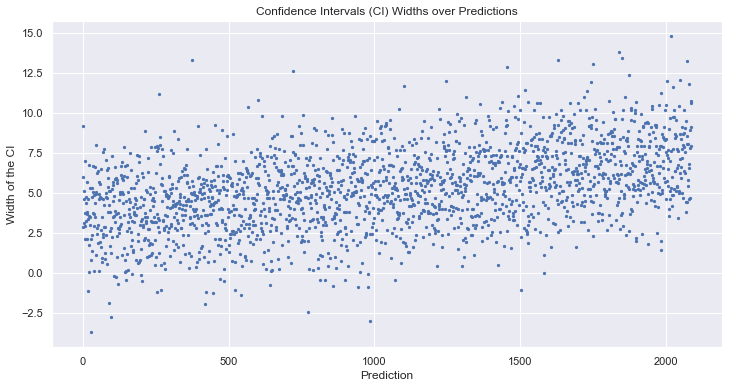

In [28]:
#Plotting the widths of the confidence intervals over the prediction time
plt.figure(figsize = (12, 6))
plt.scatter(range(len(model_pred_int_upper)),model_pred_int_upper-model_pred_int_lower, s=5)
plt.xlabel('Prediction')
plt.ylabel('Width of the CI')
plt.title('Confidence Intervals (CI) Widths over Predictions',fontsize=12)
plt.show()


In [29]:
""" Model Performance and Assessment: Getting the Prediction Results """

#Combining the predictions into a dataframe for better visualization
predictions = pd.DataFrame(data={'days between': future_days,
                                'mean': model_pred_mean,
                                'lower 95% CI': model_pred_int_lower,
                                'upper 95% CI': model_pred_int_upper})

predictions.head()

,days between,mean,lower 95% CI,upper 95% CI
0,22463,408.995815,407.649035,416.831135
1,22470,409.756635,408.528716,411.405719
2,22477,407.059204,405.061896,411.085889
3,22484,412.133496,408.816042,411.930031
4,22491,409.582234,408.825826,413.470863


In [30]:
#Getting the predictions 40 years into the future in 2049
print('The predicted levels in 2059 is', round(predictions['mean'].iloc[-1],2))
print('The 95% confidence interval is [', round(predictions['lower 95% CI'].iloc[-1],2), 
      round(predictions['upper 95% CI'].iloc[-1],2),']')


The predicted levels in 2059 is 526.06
The 95% confidence interval is [ 519.64 527.57 ]


In [31]:
#Getting the year crossing the critical threshold
print(round(predictions.loc[predictions['lower 95% CI']>450].iloc[0][0]/365.25+1958,2))

2034.31


## Appendix: Example Model Implementation
#### Purpose: to compare the RMSEs

In [32]:
#Stan code for the example model; the parameters are all the same as in the proposed one minus the quadratic terms
simple_model_data = {
    'num': len(data),
    'levels': data['level'],
    'time': data['days between']}

simple_stan = """
data {
    int<lower=0> num;  // number of collected data points
    real<lower=0> levels[num];  // data for levels         
    real<lower=0> time[num]; // data for days   
}

parameters {
    real<lower=0> c_0;  // intercept
    real<lower=0> c_1;  // 1st degree polynomial 

    real<lower=0> sigma; //random noise
    
    real<lower=0> amplitude; 
    real<lower=0,upper=pi()> phi; // phi
}


model {
    // priors 
    c_0 ~ normal(300, 30);
    c_1 ~ normal(0,10);

    sigma ~ normal(0, 8);
    
    amplitude ~ normal(0,1);
    phi ~ cauchy(0, 10);
       
    
    // model
        for (i in 1:num) {   
            levels[i] ~ normal(c_0 + c_1*time[i] +     
            amplitude*cos((2*pi()*time[i])/365.25 + phi), sigma);

    }
}
"""
simple_stan_model = pystan.StanModel(model_code=simple_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55ca55d7881f2beb16f81f4497d17249 NOW.


In [33]:
#Fitting the model to the data and printing results
simple_parameters = ['c_0','c_1','amplitude','phi','sigma']

simple_results = simple_stan_model.sampling(data=simple_model_data)
print(simple_results.stansummary(pars=simple_parameters))

Inference for Stan model: anon_model_55ca55d7881f2beb16f81f4497d17249.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0       306.08  2.2e-3   0.14 305.81 305.99 306.09 306.18 306.35   4061    1.0
c_1       4.3e-3  1.7e-7 1.1e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   3955    1.0
amplitude    2.6  2.0e-3   0.09   2.41   2.54    2.6   2.66   2.79   2329    1.0
phi       3.0e-3  5.8e-5 3.1e-3 5.5e-5 8.8e-4 2.1e-3 4.2e-3   0.01   2772    1.0
sigma       3.85  1.0e-3   0.05   3.76   3.81   3.84   3.88   3.94   2282    1.0

Samples were drawn using NUTS at Thu Dec 19 18:13:56 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


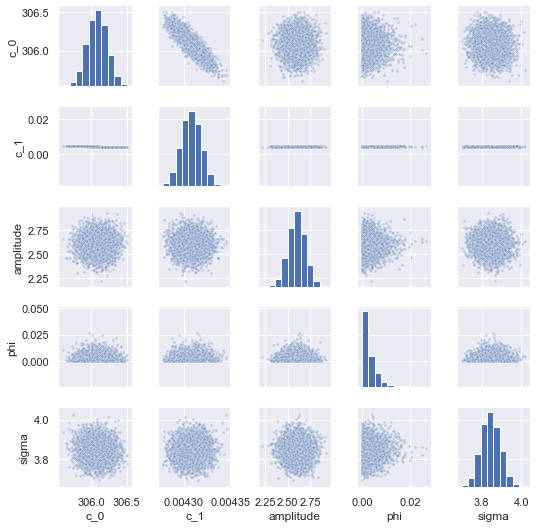

In [34]:
#Pairplots
simple_samples = simple_results.extract()
df = pd.DataFrame(data=np.transpose([simple_samples[p] for p in simple_parameters]), columns=simple_parameters)
sns.pairplot(df, size=1.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [35]:
#Getting the samples for each parameter to then generate
c0_samples1 = simple_samples['c_0']
c1_samples1 = simple_samples['c_1'] 
amp_samples1 = simple_samples['amplitude'] 
phi_samples1 = simple_samples['phi'] 
sigma_samples1 = simple_samples['sigma'] 

def simple_model(stat, time, val):  
    from numpy import arctan, sin, pi, cos
    return np.array(stats.norm.rvs(stat(c0_samples1,val) + stat(c1_samples1,val)*time + 
     stat(amp_samples1,val)*cos((2*pi*time)/365.25 + stat(phi_samples1,val)), 
                                   stat(sigma_samples1,val)))

simple_pred_mean = simple_model(np.mean, future_days, 0)
simple_pred_int_lower = simple_model(np.percentile, future_days, 2.5)
simple_pred_int_upper = simple_model(np.percentile, future_days, 97.5)

In [36]:
#Replicating data
time_days = np.array(data['days between'])
simple_model_reps = np.zeros((4000,len(time_days))) 

for s in range(4000):
    simple_model_reps[s,:] = stats.norm.rvs(c0_samples1[s] + c1_samples1[s]*time_days +
    amp_samples1[s]*cos((2*pi*time_days)/365.25 + phi_samples1[s]), 
                                   sigma_samples1[s])
                
             

In [37]:
#Getting the RMSE error for the example model
print(round(np.mean([np.mean(np.sqrt((data['level'] - simple_model_reps[i,:])**2)) for i in range(len(simple_model_reps))]),2))

4.35
